In [36]:
%matplotlib ipympl

In [37]:
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import os
import matplotlib.pyplot as plt
import umap
from wordcloud import WordCloud
import re
import cv2

In [94]:
conversion_table_path = "Data/Table/Pokemon_name_and_type.parquet"
df=pd.read_parquet(conversion_table_path)

In [41]:
colors = {
    'Plant': np.array([34, 139, 34]),       # Green
    'Fire': np.array([255, 69, 0]),           # Red-Orange
    'Water': np.array([30, 144, 255]),         # Blue
    'Bug': np.array([128, 128, 0]),      # Olive
    'Normal': np.array([169, 169, 169]),     # Dark Gray
    'Poison': np.array([128, 0, 128]),       # Purple
    'Electric': np.array([255, 215, 0]),     # Gold
    'Ground': np.array([210, 105, 30]),         # Chocolate
    'Fairy': np.array([255, 192, 203]),        # Pink
    'Fighting': np.array([205, 92, 92]),       # Indian Red
    'Psychic': np.array([123, 104, 238]),        # Medium Slate Blue
    'Rock': np.array([139, 69, 19]),        # Saddle Brown
    'Ghost': np.array([138, 43, 226]),     # Blue Violet
    'Ice': np.array([135, 206, 235]),      # Sky Blue
    'Dragon': np.array([106, 90, 205]),      # Slate Blue
    'Dark': np.array([47, 79, 79]),      # Dark Slate Gray
    'Steel': np.array([192, 192, 192]),      # Silver
    'Flying': np.array([70, 130, 180])          # Steel Blue
}

In [42]:
def padding(img, expected_size):
    desired_size = expected_size
    delta_width = desired_size[0] - img.size[0]
    delta_height = desired_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

In [43]:
path = "Data/Images"
image_list = os.listdir(path)
dic = {}
expected_size = (128,128)
for image_name in image_list:
    index=image_name.split("_")[0]
    img = Image.open(os.path.join(path, image_name))
    img.thumbnail(expected_size, Image.Resampling.LANCZOS)
    img = padding(img, expected_size)
    numpy_array = np.array(img)
    dic[index]=numpy_array
df["image"]=df.index.map(dic)

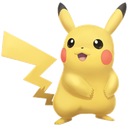

In [44]:
Image.fromarray(df.loc["0025","image"])

## UMAP

In [45]:
df["vector"] = df["image"].apply(lambda x:x[:,:,:3].flatten())

In [57]:
reducer = umap.UMAP()
types = ["Fire", "Electric", "Water"]
%time u = reducer.fit_transform(np.stack(df.loc[df["Type 1"].isin(types), "vector"], axis=0))

CPU times: total: 5.66 s
Wall time: 3.07 s


In [58]:
df["color"]=df["Type 1"].map(colors)

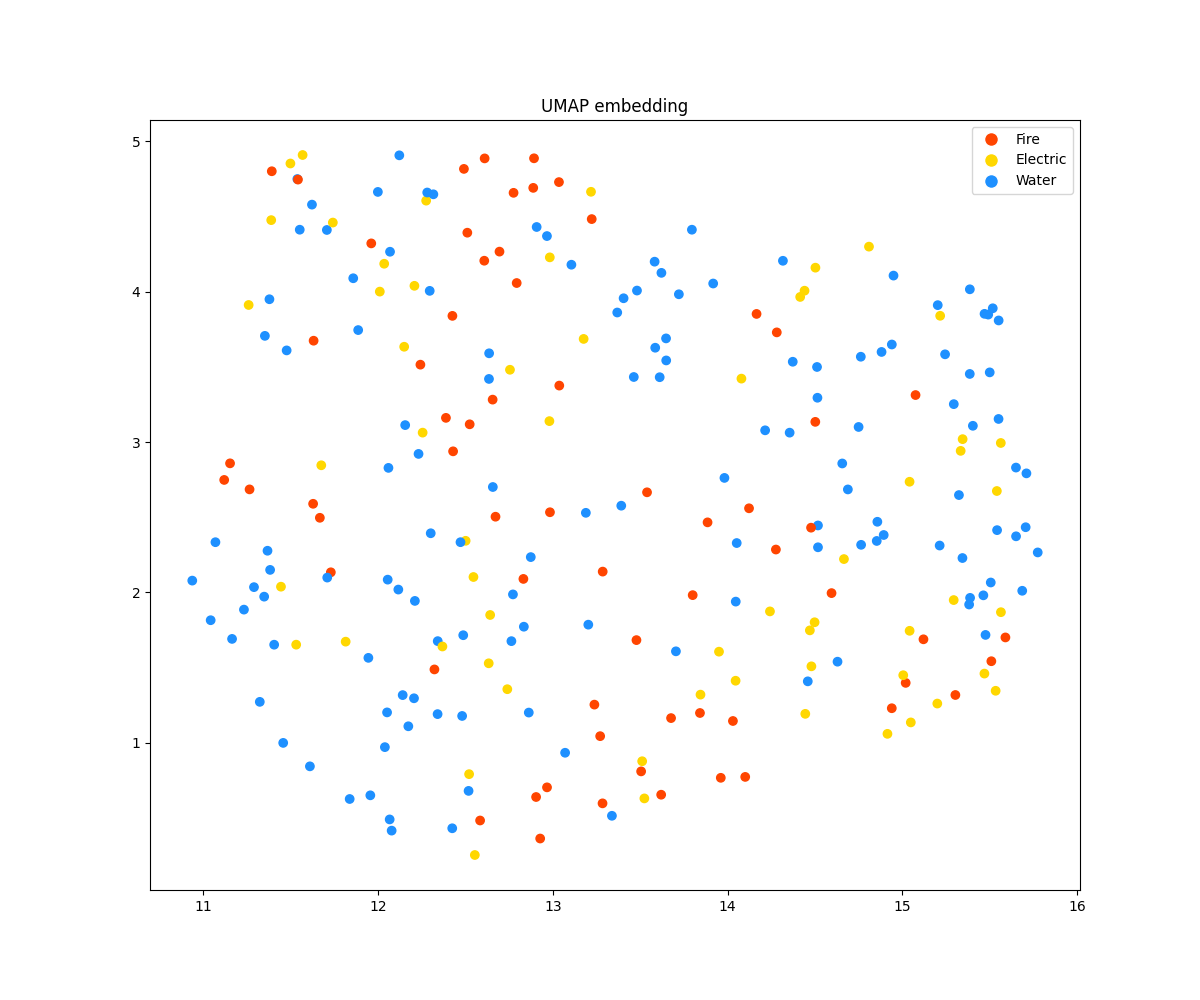

In [59]:
plt.figure(figsize=(12, 10))  # Adjust the width and height as needed
plt.scatter(u[:,0], u[:,1], c=df.loc[df["Type 1"].isin(types), "color"]/255)
# Add legend with types and colors
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                              markersize=10, markerfacecolor=colors[label]/255) for label in types]
plt.legend(handles=legend_handles, labels=types)

plt.title('UMAP embedding')
plt.show()

## Mean color

In [60]:
img_array = df.loc["0001", "image"]
img = Image.fromarray(img_array)

In [61]:
def nan_mean_dataframe(rgb, alpha):
    image_temp = rgb.copy().astype(np.float32)
    image_temp[alpha == 0] = np.nan
    return np.nanmean(image_temp.reshape(-1,3), axis=0)

df["rgb_values"] = df["image"].apply(lambda x:x[:,:,:3])
df["alpha_channel"] = df["image"].apply(lambda x:x[:,:,3])
df["mean_color_value"] = df[["rgb_values", "alpha_channel"]].apply(lambda x:nan_mean_dataframe(x[0], x[1]), axis=1)

C:\Users\wande\AppData\Local\Temp\ipykernel_1392\470956786.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["mean_color_value"] = df[["rgb_values", "alpha_channel"]].apply(lambda x:nan_mean_dataframe(x[0], x[1]), axis=1)


In [62]:
df[["Type 1","mean_color_value"]]

,Type 1,mean_color_value
Number,,
0001,Plant,"[109.89778, 156.39117, 134.19037]"
0002,Plant,"[101.859924, 139.78908, 140.74796]"
0003,Plant,"[104.78638, 119.612144, 116.31939]"
0004,Fire,"[186.51294, 146.77669, 119.91799]"
0005,Fire,"[189.45543, 122.29989, 103.43847]"
...,...,...
1021,Electric,"[178.34544, 164.97894, 147.11147]"
1022,Rock,"[167.60175, 151.88596, 131.8171]"
1023,Steel,"[123.41835, 161.08537, 160.64685]"


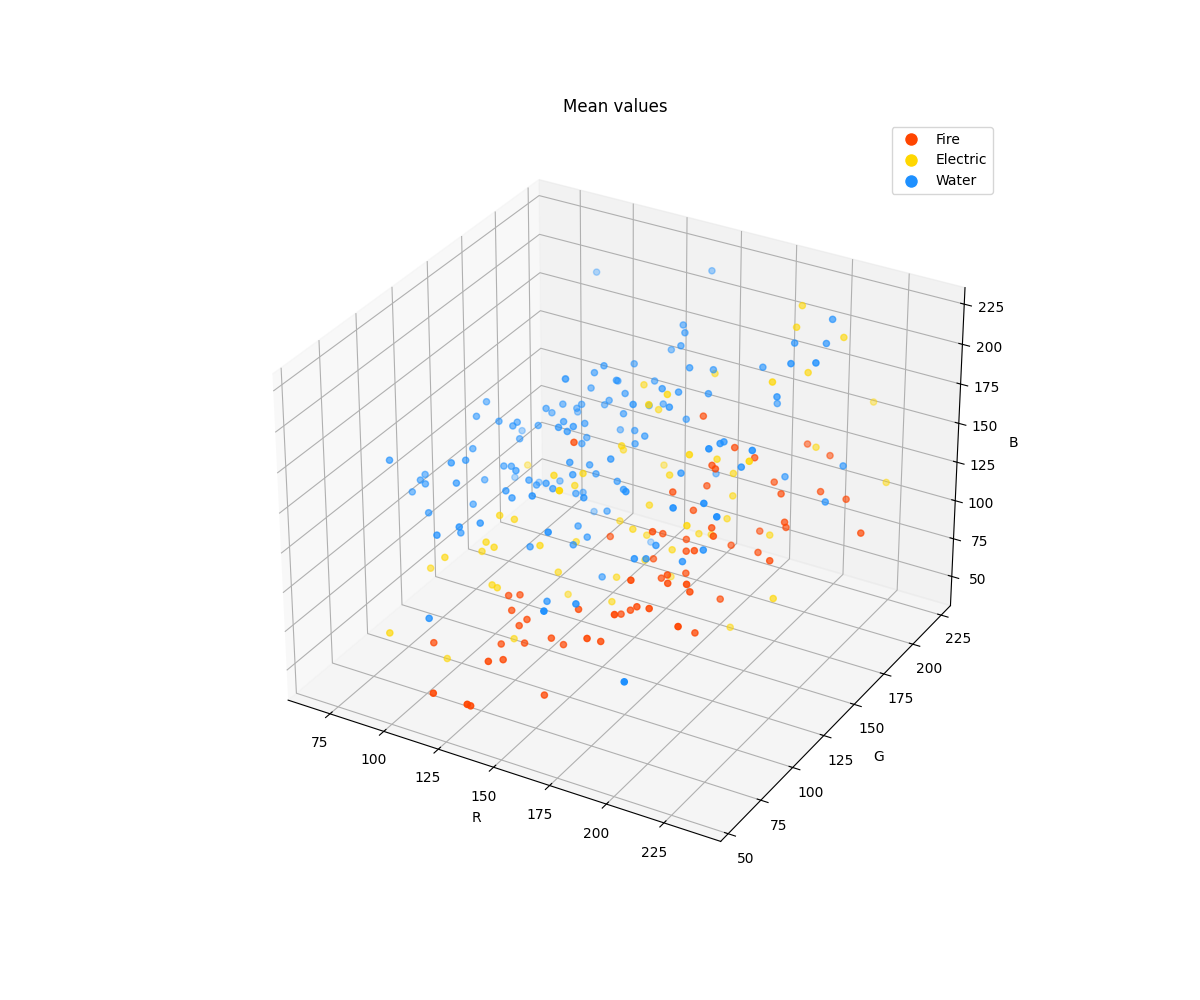

In [63]:
types = ["Fire", "Electric", "Water"]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
u = np.stack(df.loc[df["Type 1"].isin(types), "mean_color_value"], axis=0)
scatter = ax.scatter(u[:, 0], u[:, 1], u[:, 2], c=df.loc[df["Type 1"].isin(types),"color"]/255)

# Add legend with types and colors
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                             markersize=10, markerfacecolor=colors[label]/255) for label in types]
ax.legend(handles=legend_handles, labels=types)

ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')

ax.set_title('Mean values')
plt.show()

In [64]:
def extract_dominant_color(image, k=3):
    pixels = image["rgb_values"][image["alpha_channel"] != 0]
    # Reshape the image to be a list of pixels
    pixels = pixels.reshape((-1, 3))
    
    # Convert to float
    pixels = np.float32(pixels)
    
    # Define criteria for k-means
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    
    # Apply k-means clustering
    compactness, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Get the counts for each label
    label_counts = np.bincount(labels.flatten())
    
    # Get the index of the most frequent label (dominant color)
    most_dominant_label = np.argmax(label_counts)
    
    # Get the most dominant color
    most_dominant_color = centers[most_dominant_label]

    # Convert centers to integer
    most_dominant_color = np.uint8(most_dominant_color)
    
    # Return the dominant colors
    return most_dominant_color

In [65]:
df["dominant_color"] = df[["rgb_values", "alpha_channel"]].apply(extract_dominant_color, axis=1)

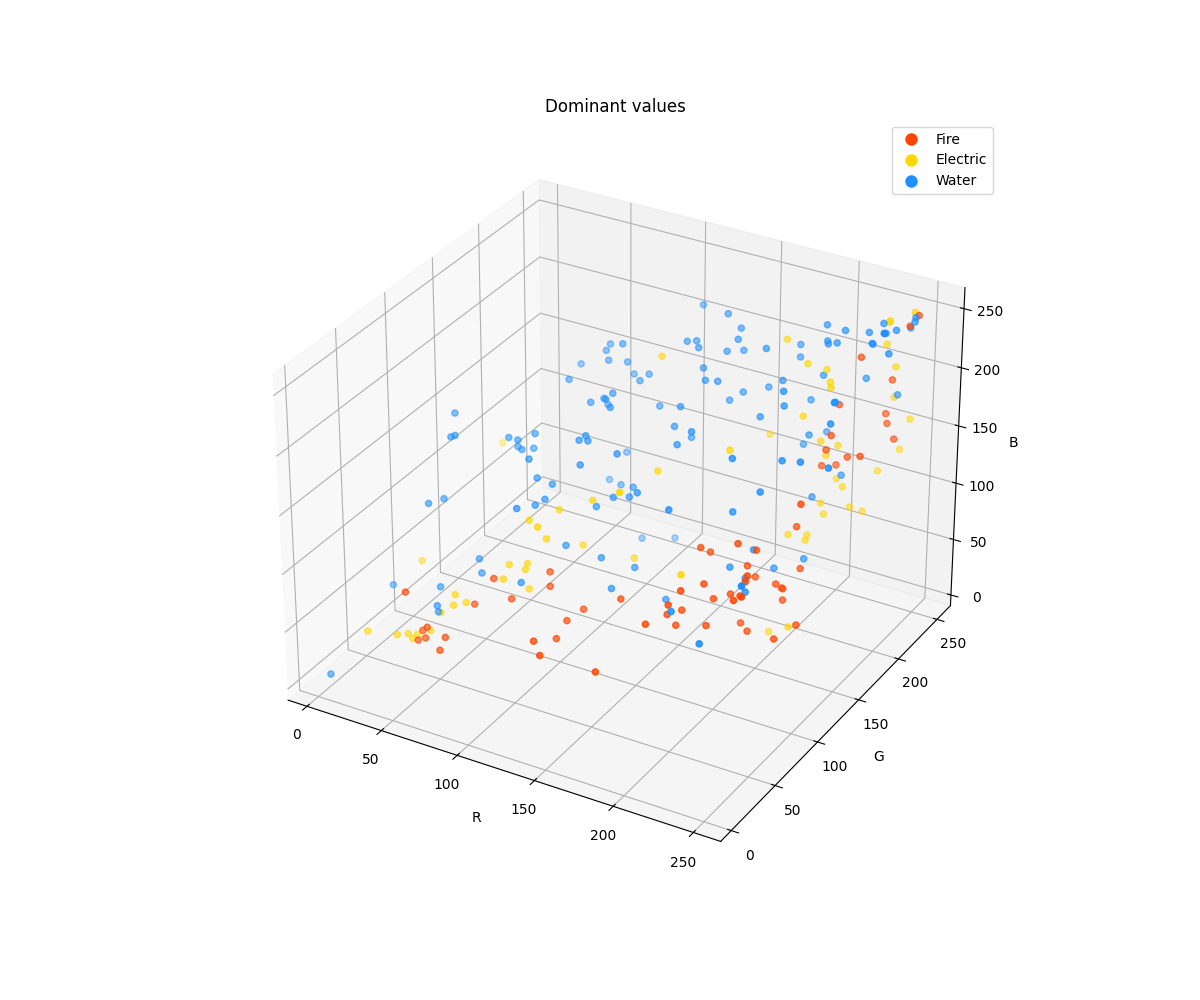

In [66]:
types = ["Fire", "Electric", "Water"]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
u = np.stack(df.loc[df["Type 1"].isin(types), "dominant_color"], axis=0)
scatter = ax.scatter(u[:, 0], u[:, 1], u[:, 2], c=df.loc[df["Type 1"].isin(types),"color"]/255)

# Add legend with types and colors
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                             markersize=10, markerfacecolor=colors[label]/255) for label in types]
ax.legend(handles=legend_handles, labels=types)

ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')

ax.set_title('Dominant values')
plt.show()

# Text data

In a second time, we propose to use textual data to infer the type of the pokemon. Indeed Pokemons often have meaningful names, for instance Hitokage is litteraly a lizard in fire hence its name is 火 (hi) which means fire and 蜥蜴 (tokage) which means lizard. Similar wordplays can be found in english and french, Charmander is the contraction of "Char" (to burn) and "mander" from Salamander. Salamèche is the contraction of "Sala" from Salamandre and "mèche" (fuse).

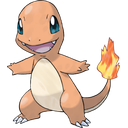

In [67]:
Image.fromarray(df.loc["0004","image"])

In [68]:
df[["French", "English", "German", "Kanas", "Type 1", "Type 2"]].iloc[20:30]

,French,English,German,Kanas,Type 1,Type 2
Number,,,,,,
0021,Piafabec,Spearow,Habitak,オニスズメ,Normal,Flying
0022,Rapasdepic,Fearow,Ibitak,オニドリル,Normal,Flying
0023,Abo,Ekans,Rettan,アーボ,Poison,None
0024,Arbok,Arbok,Arbok,アーボック,Poison,None
0025,Pikachu,Pikachu,Pikachu,ピカチュウ,Electric,None
0026,Raichu,Raichu,Raichu,ライチュウ,Electric,None
0027,Sabelette,Sandshrew,Sandan,サンド,Ground,None
0028,Sablaireau,Sandslash,Sandamer,サンドパン,Ground,None
0029,Nidoran♀,Nidoran♀,Nidoran♀,ニドラン♀,Poison,None


Of course the textual information can be way more complicated to interpret. For instance the famous Pikachu has not really any meaning in any other languages besides japanese. And even in japanese the meaning is not that easy to retrieve. The name Pikachu comes from the contraction between the onomatopoeias ピカピカ (pikapika), a sparkling sound, and チューチュー (chūchū), the squeaking sounds of a mouse. And indeed Pikachu is an electric mouse !

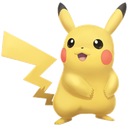

In [69]:
Image.fromarray(df.loc["0025","image"])

We can perform a textual analysis to see the most common root between the different names. We will perform it on japanese since this is the original language but the analysis can be done on the other language too.

In [72]:
def get_substrings(word, n):
    return [word[i:i+n].lower() for i in range(len(word) - n + 1)]

def create_word_cloud(df, language, type):
    occurences = df.loc[(df["Type 1"] == type) | (df["Type 2"] == type),language+"_substrings"].value_counts()

    print(occurences)

    dic = occurences[occurences>1].to_dict() 

    wordcloud = WordCloud(width=800, height=400, background_color ='white', font_path="fonts/BIZ-UDGOTHICR.TTC", prefer_horizontal=1).generate_from_frequencies(dic)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Remove axis
    plt.show()

Kanas_substrings
デン    7
ライ    7
エレ    6
チュ    5
ンダ    3
     ..
トム    1
シマ    1
ママ    1
ゼブ    1
ルラ    1
Name: count, Length: 187, dtype: int64


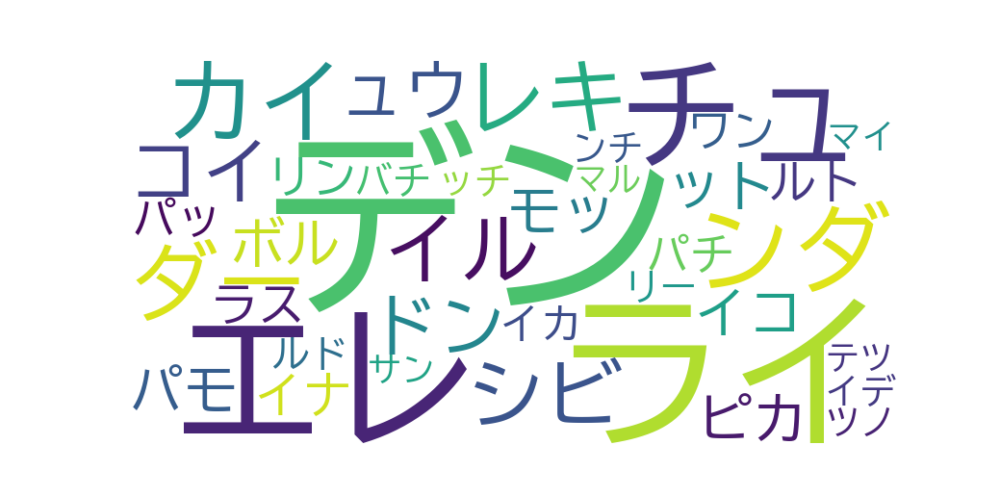

In [74]:
language = "Kanas"
pokemon_type = "Electric"

substring_length = 2

df[language+"_substrings"] = df[language].apply(lambda x: get_substrings(x, substring_length))
df_name = df[[language+"_substrings", "Type 1", "Type 2"]].explode(language+"_substrings")

create_word_cloud(df_name, language, pokemon_type)

One can effectively notice the multiple Pokemons which an electric type share the kanas :
- デン (den) which comes from 電気 (denki - electricity)
- ライ (rai) which comes from 雷 (rai - thunder)
- エレ (ele) which can be found in the japanese pronunciation of electricity (エレキ), electronics (エレクトロニクス)

Kanas_substrings
ドラ    6
リュ    4
ゴン    4
ライ    4
ラゴ    3
     ..
シラ    1
ラム    1
ゼク    1
クロ    1
イコ    1
Name: count, Length: 209, dtype: int64


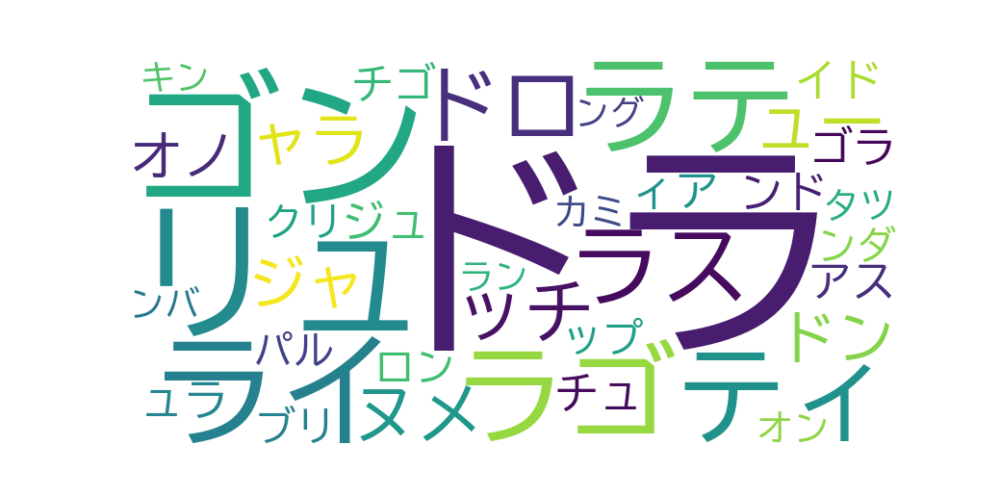

In [75]:
pokemon_type = "Dragon"
create_word_cloud(df_name, language, pokemon_type)

For the Dragon type, multiple pokemons share the kanas :
- ドラ (dora) and ゴン (gon) which comes directly from the english word dragon (pronounced doragon in japanese)
- リュ (ryu) which means 竜 (ryuu - dragon)

# Class distribution

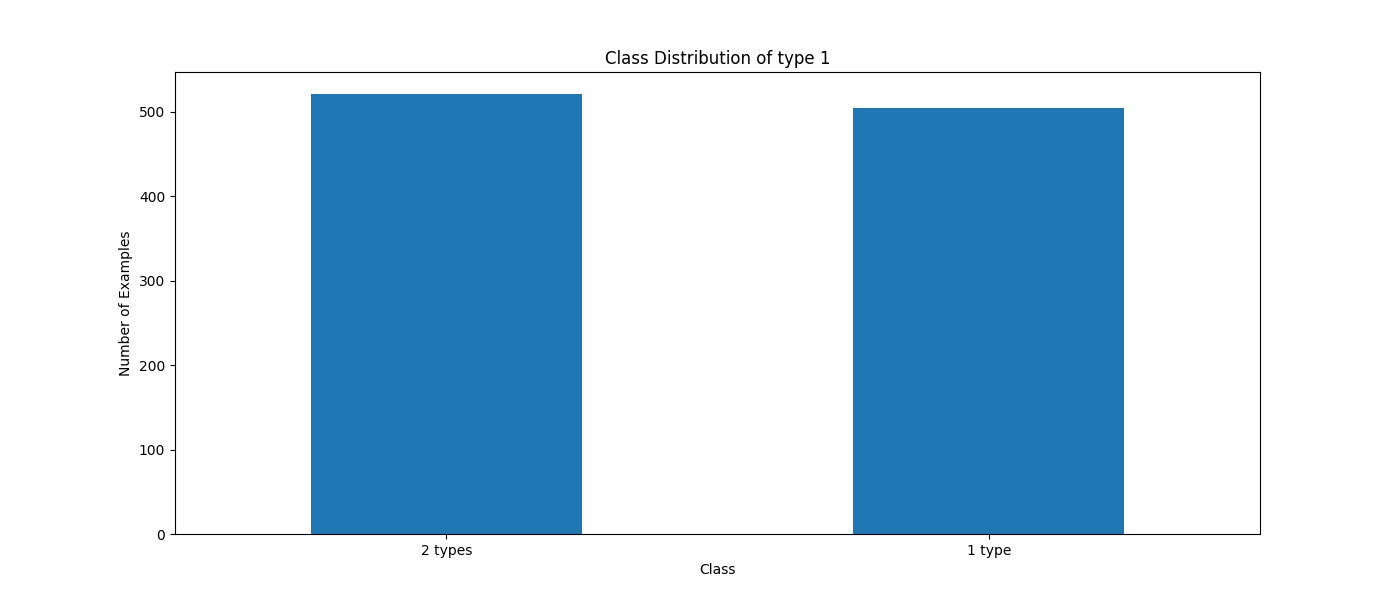

In [79]:
df['2 types'] = "1 type"
df.loc[df['Type 2'].notna(), '2 types'] = "2 types"
class_counts = df['2 types'].value_counts()

plt.figure(figsize=(14, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution of type 1')
plt.xlabel('Class')
plt.ylabel('Number of Examples')
plt.xticks(rotation=0)
plt.show()

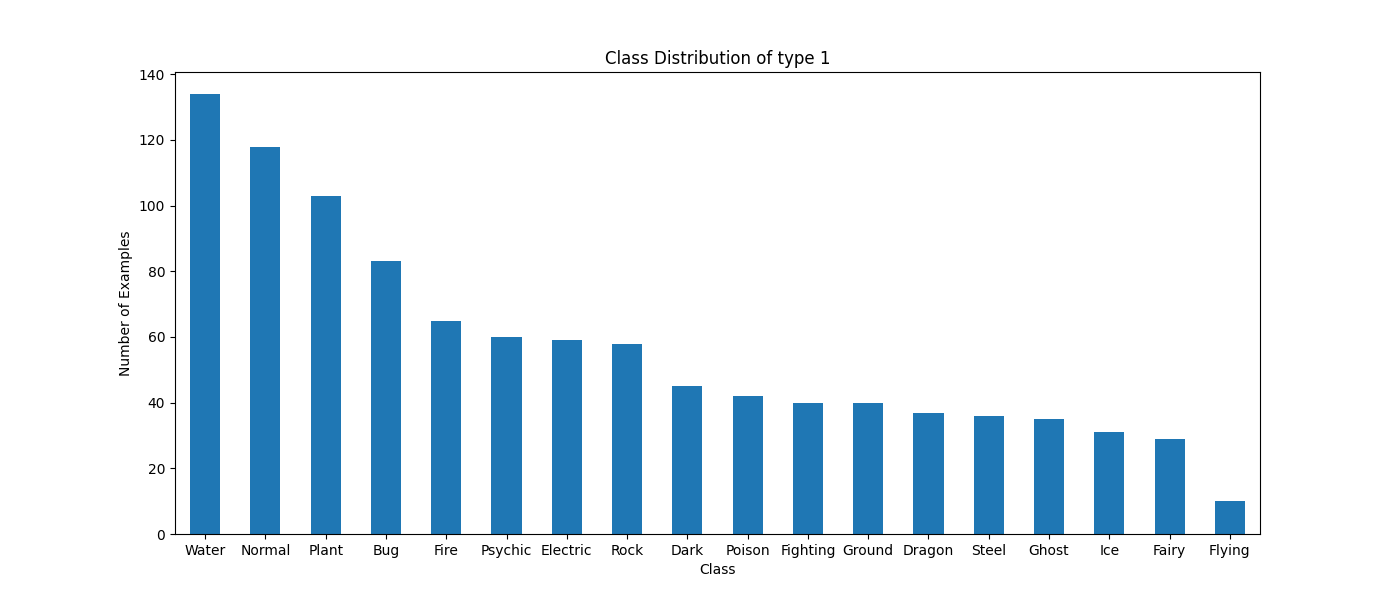

In [78]:
class_counts = df['Type 1'].value_counts(dropna=False)

plt.figure(figsize=(14, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution of type 1')
plt.xlabel('Class')
plt.ylabel('Number of Examples')
plt.xticks(rotation=0)
plt.show()

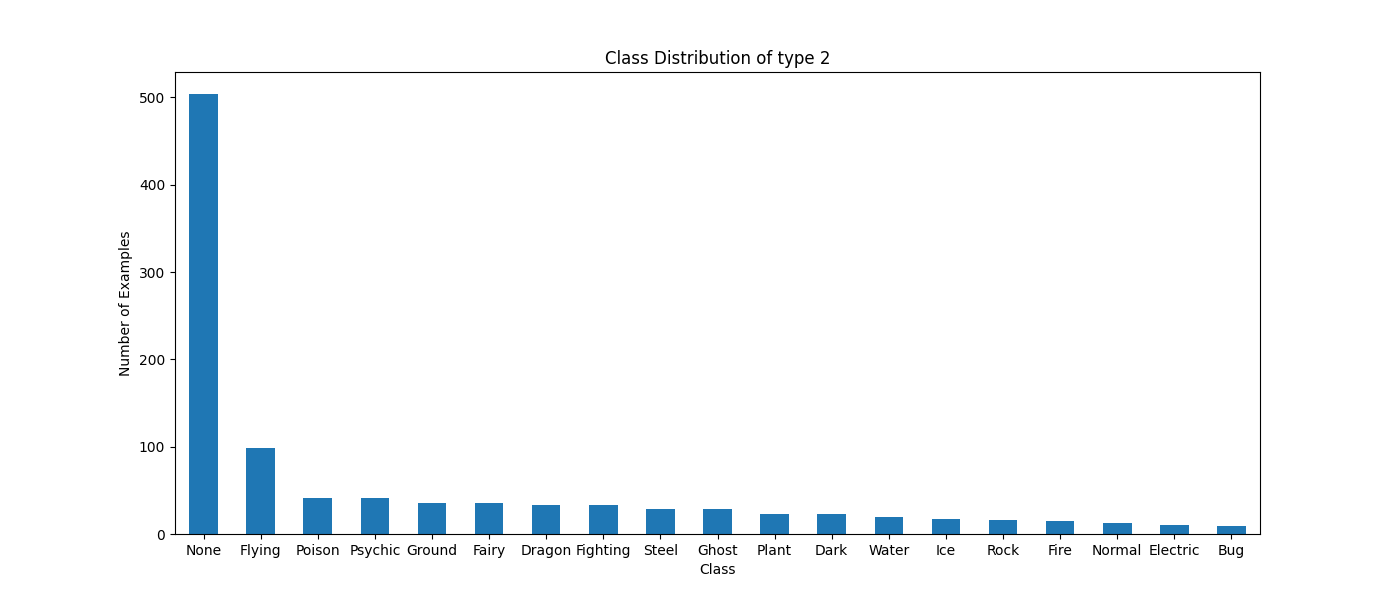

In [80]:
class_counts = df['Type 2'].value_counts(dropna=False)

plt.figure(figsize=(14, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution of type 2')
plt.xlabel('Class')
plt.ylabel('Number of Examples')
plt.xticks(rotation=0)
plt.show()

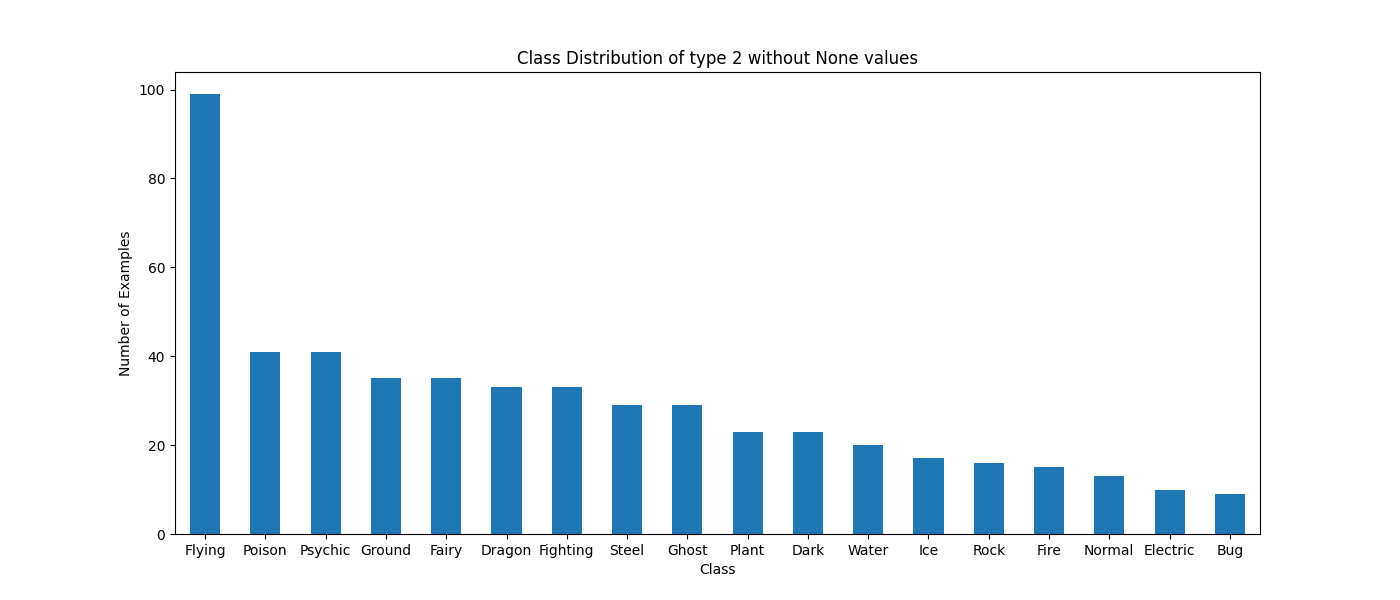

In [81]:
class_counts = df['Type 2'].value_counts()

plt.figure(figsize=(14, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution of type 2 without None values')
plt.xlabel('Class')
plt.ylabel('Number of Examples')
plt.xticks(rotation=0)
plt.show()

One can also transform the none values of the second type into the first type.

In [82]:
df['Type2_WO_None'] = df['Type 2']
df.loc[df['Type 2'].isna(),'Type2_WO_None'] = df.loc[df['Type 2'].isna(),'Type 1']

Text(0, 0.5, 'First Type')

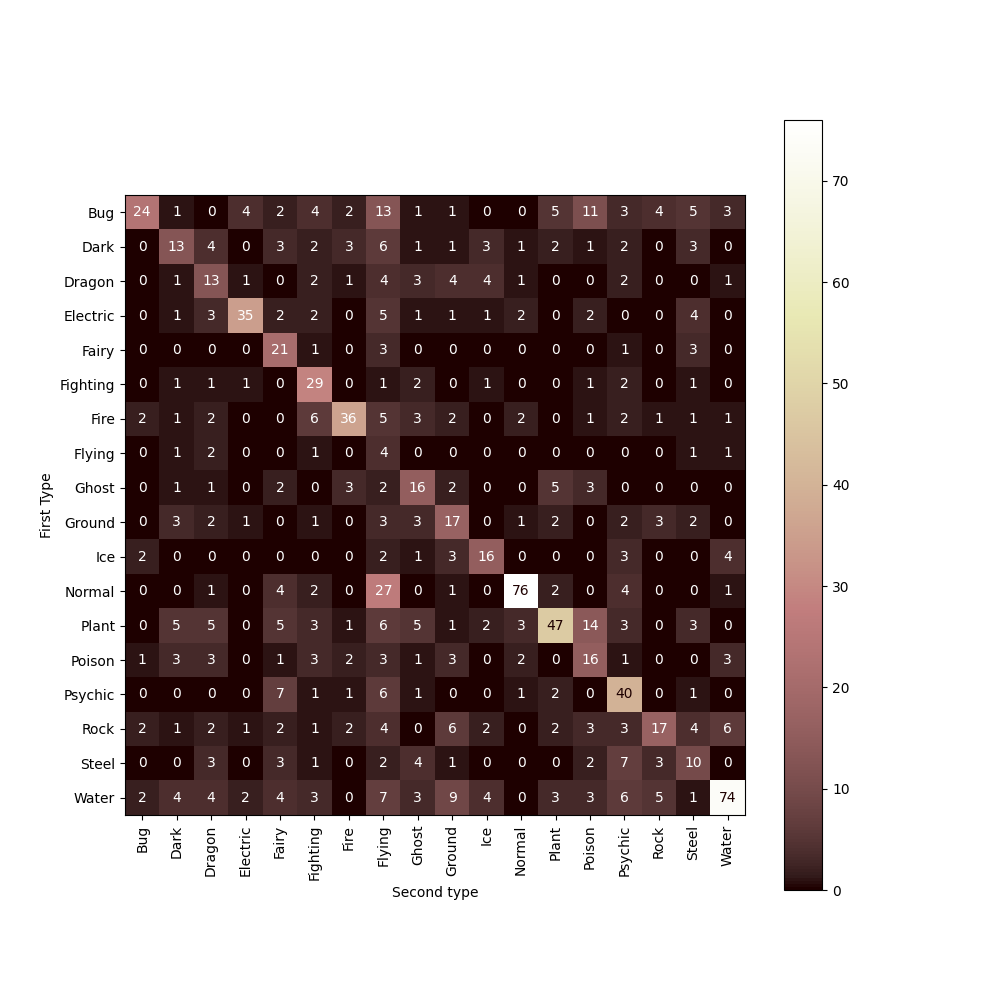

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df['Type 1'], df['Type2_WO_None'])
unique_label = np.unique([df["Type 1"], df["Type2_WO_None"]])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_label)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, xticks_rotation='vertical', cmap="pink")
ax.set_xlabel('Second type')
ax.set_ylabel('First Type')